This script calculates odds ratios and p-values for a specific cluster compared to all other clusters.
The results will be used to generate volcano plots.

Key processes in this script:
1. **Compute odds ratios and p-values for each diagnosis**  
   - **Input:** `Data/ad_diagnosis.csv`, `kmeans_clusters_n5_rdm42_diagnosis.pkl`
2. **Apply Bonferroni correction** to adjust for multiple comparisons.
3. **Classify diagnoses** based on statistical significance and effect size:  
   - **"ClusterX"** if log2(odds ratio) > 1 and p-value is significant.  
   - **"Other Clusters"** if log2(odds ratio) < -1 and p-value is significant.
   - **"Significant"** if -1 < log2(odds ratio) < 1 and p-value is significant.  
   - **"Not Significant"** for all others.
4. **Save results** for further analysis:  
   - **All odds ratios and p-values:** `volcano_c{i}_other_ICD10.pickle`
   - **Filtered significant results:** `Data/volcano_significant_c{i}_other_ICD10.csv`

The output provides insights into statistically significant comorbidities within each cluster.


In [1]:
import pickle
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from scipy.stats import fisher_exact
from matplotlib import cm
import statsmodels.api as sm
import pickle
from joblib import dump
from joblib import load
import plotly.io as pio
from math import log10, log2
from scipy.stats import chi2_contingency

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
%run -i setupfunc.py

# Load analysis datasets

In [4]:
alldiag = pd.read_csv('Data/ad_diagnosis.csv')
alldiag['ValueL'] = alldiag['Value'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte

In [5]:
alldiag.rename(columns={'PatientDurableKey':'PatientID','Value':'ICD10','ValueL':'ICD10_chape'}, inplace=True)

In [6]:
alldiag = alldiag[alldiag['ICD10'].notna()]

In [7]:
alldiag = alldiag[~alldiag['DiagnosisName'].str.contains('alzheimer', flags=re.IGNORECASE)]

In [8]:
with open('kmeans_clusters_n5_rdm42_diagnosis.pkl', 'rb') as f:
    df = pickle.load(f)

In [9]:
df = df[['Cluster_0','Cluster_1', 'Cluster_2', 'Cluster_3','Cluster_4', 'Cluster']]

In [10]:
alldiag_cluster = alldiag.join(df, on='PatientID', how='left')

In [11]:
# Remove records containing 'IMO' in the 'ICD10' column
alldiag_cluster = alldiag_cluster[~alldiag_cluster['ICD10'].str.contains('IMO', na=False)]

# Comparing a specific cluster vs all other clusters

In [12]:
diagkeys = ['ICD10']

In [13]:
focus_cluster = 'Cluster_1'

In [14]:
alldiag_f_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==1]
alldiag_nonf_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==0]

In [15]:
total_f = alldiag_f_cluster['PatientID'].nunique() #Total cluster0 patients
total_nonf = alldiag_nonf_cluster['PatientID'].nunique() #Total other clusters' patients

In [16]:
countDiagnosis_f = countPtsDiagnosis_Dict(alldiag_f_cluster, total_f)

In [17]:
countDiagnosis_nonf = countPtsDiagnosis_Dict(alldiag_nonf_cluster, total_nonf)

In [18]:
# Create dictionary of dataframes of contingency table for each diagnosis
alldiagcount = dict() 

jointype = 'outer' # outer join allows us to have contingency table with 0 as entries

for n in diagkeys:
    alldiagcount[n] = countDiagnosis_f[n].merge(countDiagnosis_nonf[n], how = jointype, on = n, suffixes=('_c1','_nonc1'))
    alldiagcount[n] = alldiagcount[n].set_index(n)
    if jointype == 'outer': # replace nan's
        nanreplace = dict(zip( list(alldiagcount[n].columns) , [0,total_f,0,total_nonf] ))
        alldiagcount[n] =  alldiagcount[n].fillna(value=nanreplace)

In [19]:
# compute p-values.
chitest_count = sigTestCountsDict(alldiagcount, diagkeys, verbose = 1, diag = True)

Significance testing on  ICD10
ICD10 : Amount:  10448
	 Fisher Exact for <5 pts in a category, num: 8337
		 fisher: (8337, 2)
		 fisher1: (8337, 8)
	 Chi square for >=5 pts in a category, num: 2111
		 fisher (2111, 4)
		 chisquare: (2111, 9)
		 combined 1: (10448, 13)
		 combined 2: (10448, 14)
	 Final num:  10448


In [20]:
# Dictionary to store DataFrames
label_data_dict = {}

for n in diagkeys:
    # Bonferroni correction: Adjusting the significance threshold to account for multiple comparisons
    bc = .05 / chitest_count[n].shape[0]

    # Add index column for reference
    chitest_count[n]['index'] = chitest_count[n].index
    
    # Initialize a significance label array with "Not Significant" as the default value
    sig = np.full(shape=(chitest_count[n].shape[0],), fill_value='Not Significant') 

    # Mark observations as "Significant" if the p-value is below the Bonferroni-corrected threshold
    sig[chitest_count[n]['pvalue'] < bc] = 'Significant'

    # Further classify significant observations:
    # - "Cluster1" if the log2 odds ratio is greater than 1
    # - "Other Clusters" if the log2 odds ratio is less than -1
    mask = (chitest_count[n]['pvalue'] < bc) & (chitest_count[n]['log2_oddsratio'] > 1)
    sig[mask] = 'Cluster1'

    mask = (chitest_count[n]['pvalue'] < bc) & (chitest_count[n]['log2_oddsratio'] < -1)
    sig[mask] = 'Other Clusters'
    
    # Assign the classification labels to the DataFrame
    chitest_count[n]['sig'] = sig

    # Create a copy of the DataFrame to avoid modifying the original dataset
    df = chitest_count[n].copy()
 
    # Extract statistically significant data (excluding "Not Significant" cases)
    significant_df = df[df['sig'] != 'Not Significant'].copy()

    # Prepare the label data for visualization
    label_data = [
        {
            'Label': row['index'],  # The identifier for each record
            'X': row['log2_oddsratio'],  # X-axis value (effect size)
            'Y': row['-log_pvalue'],  # Y-axis value (statistical significance)
            'ICD10_chape': row['ICD10_chape']  # Associated ICD-10 classification
        }
        for idx, row in significant_df.iterrows()
    ]

    # Convert the label data into a pandas DataFrame
    df_labels = pd.DataFrame(label_data)

    # Save the extracted data as a CSV file for further analysis
    df_labels.to_csv(f'Data/volcano_significant_c1_other_{n}.csv', index=False)


In [21]:
# save
import pickle 
pickle.dump(chitest_count, open('Data/volcano_c1_other_ICD10.pickle', 'wb'))

In [22]:
custom_palette = {
    "Not Significant": "#949494",
    "Significant": "#51A0D5",
    "Cluster1": "#EC719E",
    "Other Clusters": "#2CB97C"
}

custom_colors = ["#949494", "#51A0D5", "#EC719E", "#2CB97C"]

In [23]:
from adjustText import adjust_text

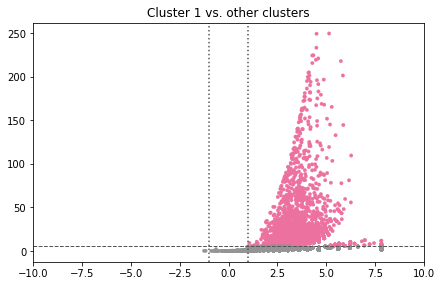

In [24]:
plot_diagkeys = ['ICD10']

# Dictionary to store the DataFrame for saving
label_data_dict = {}

for n in plot_diagkeys:
    # Bonferroni correction threshold
    bc = .05 / chitest_count[n].shape[0]  
    
    # Add the index as a column in the DataFrame
    chitest_count[n]['index'] = chitest_count[n].index  
    df = chitest_count[n].copy()  

    # Plot settings
    fig, ax = plt.figure(figsize=(7, 4.4)), plt.gca()  
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue',  
                        hue='sig', palette=custom_palette,  
                        edgecolor=None, s=12, ax=ax)  
    
    # Set x-axis limits
    plt.xlim([-10, 10])  
    
    # Add reference lines
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)  # Bonferroni correction threshold
    plt.axvline(1, color='#555555', linestyle=':')  # Log2 OR = 1 threshold
    plt.axvline(-1, color='#555555', linestyle=':')  # Log2 OR = -1 threshold

    # Remove labels and legend
    plt.xlabel('')  
    plt.ylabel('')  
    plt.title('Cluster 1 vs. other clusters')  
    plt.legend().remove()  

    # Save the figure
    plt.savefig("Figures/volcano_c1.pdf", dpi=600, format="pdf", bbox_inches="tight")  

    # Display the plot
    plt.show()
